In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

def getfinalstate(model):
    N = len(model.params.Cmat)
    V = len(model.state_vars)
    T = model.getMaxDelay()+1
    state = np.zeros((N, V, T))
    for n in range(N):
        for v in range(V):
            if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
                state[n,v,:] = model.state[model.state_vars[v]][n, -T:]
                
            else:
                state[n,v,:] = model.state[model.state_vars[v]][n]
    return state

def setinitstate(model, state):
    N = len(model.params.Cmat)
    V = len(model.init_vars)
    T = model.getMaxDelay()+1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:,v,-T:]
            else:
                model.params[model.init_vars[v]] = state[:,v,-1]

    return

In [2]:
# We import the model
model = ALNModel()
model.params.de = 0.2
model.params.di = 0.1

model.params.a = 4
model.params.b = 0
model.params.tauA = 1.

##### works as long as following two parameters are the same
model.params.mue_ext_mean = 1.5
model.params.mui_ext_mean = 0.5
model.params.sigma_ou = 0.

for iv in model.init_vars:
    if "rates" in iv:
        model.params[iv] = np.zeros((1,model.getMaxDelay()+1))
    elif "IA" in iv:
        model.params[iv] = 30 * np.ones((1,model.getMaxDelay()+1))
    else: model.params[iv] = np.zeros((1,))

model.params.mue_ou = model.params.mue_ext_mean * np.ones((1,))
model.params.mui_ou = model.params.mui_ext_mean * np.ones((1,))

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 1.

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
model.run()

finalstate = getfinalstate(model)
print("final mui = ", finalstate[0,3])
print("final mue = ", finalstate[0,2])
print("final IA = ", finalstate[0,4])
print("final sie = ", finalstate[0,7])
setinitstate(model, finalstate)

final mui =  [0.02488161 0.02488161 0.02488161]
final mue =  [0.07553952 0.07553952 0.07553952]
final IA =  [12.98366803 11.70946785 10.56571046]
final sie =  [0.00280174 0.00280174 0.00280174]


In [7]:
duration = 0.4 # min 4 last input
model.params["duration"] = duration
model.run()
amplitude = 1e0
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
#input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well
input[0,1] = 10.*amplitude
input[0,3] = -5.*amplitude
#input[0,5] = 8.*amplitude
#input[0,6] = -6.*amplitude
#input[0,8] = -2.*amplitude
#input[0,14] = 8.*amplitude

(1, 3, 5)


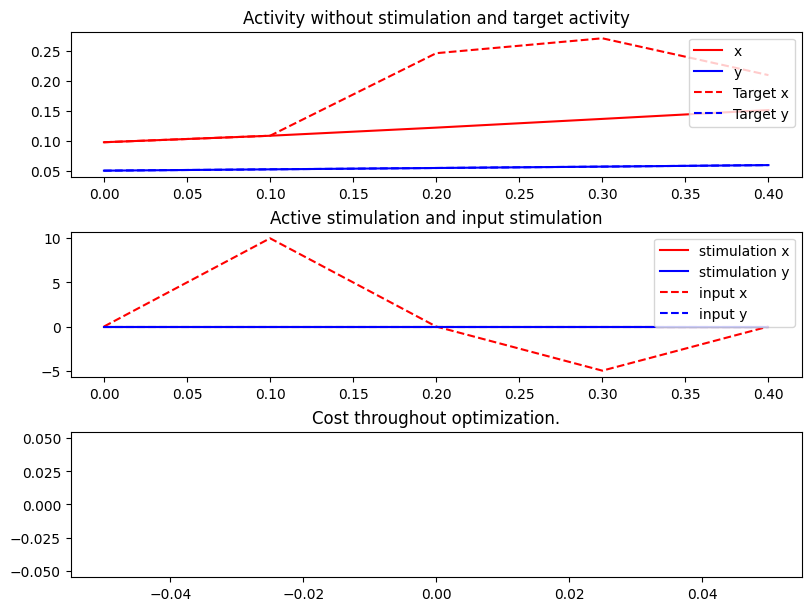

e rate


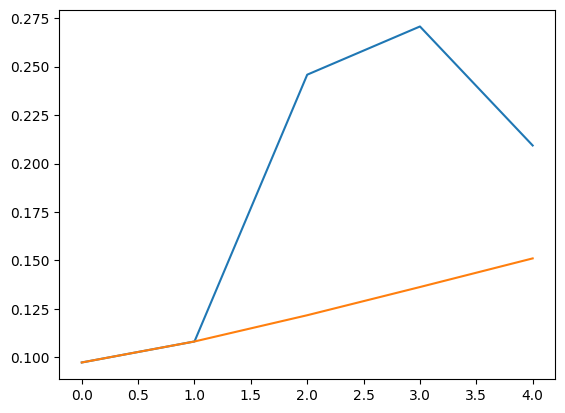

I rate


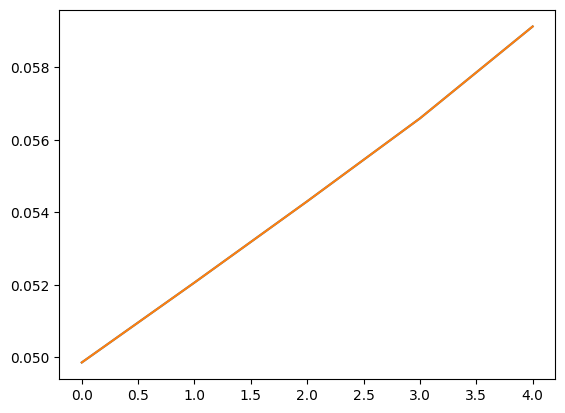

IA
[0.         0.         0.02120937 0.04032596 0.04628229]


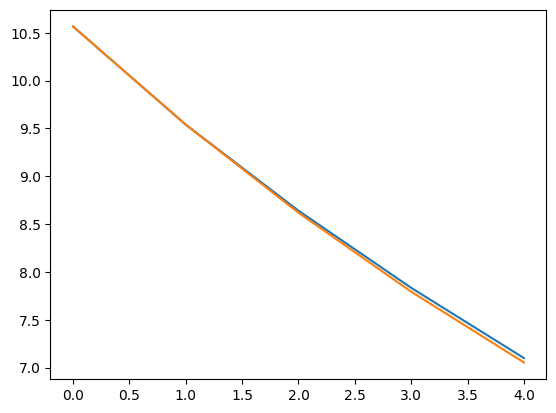

In [8]:
# We set the stimulus in x and y variables, and run the simulation
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input
model.run()

# Define the result of the stimulation as target
t0 = np.concatenate( (model.params["rates_exc_init"][:, np.newaxis, -1], model.params["rates_inh_init"][:, np.newaxis, -1], model.params["IA_init"][:, np.newaxis, -1]), axis=1)[:,:,np.newaxis]
t1 = np.stack( (model.rates_exc, model.rates_inh, model.IA), axis=1)
target = np.concatenate((t0, t1), axis=2)
print(target.shape)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
s0 = np.concatenate( (model.params["rates_exc_init"][:, np.newaxis, -1], model.params["rates_inh_init"][:, np.newaxis, -1], model.params["IA_init"][:, np.newaxis, -1]), axis=1)[:,:,np.newaxis]
s1 = np.stack( (model.rates_exc, model.rates_inh, model.IA), axis=1)
state = np.concatenate((s0, s1), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

if True:
    print("e rate")
    plt.plot(target[0,0,:])
    plt.plot(state[0,0,:])
    #plt.ylim(0.9*state[0,1,-1],1.1*state[0,1,-1])
    plt.show()

if True:
    print("I rate")
    plt.plot(target[0,1,:])
    plt.plot(state[0,1,:])
    #plt.ylim(0.9*state[0,1,-1],1.1*state[0,1,-1])
    plt.show()

if True:
    print("IA")
    plt.plot(target[0,2,:])
    plt.plot(state[0,2,:])
    print(target[0,2,:] - state[0,2,:])
    #plt.ylim(0.9*state[0,1,-1],1.1*state[0,1,-1])
    plt.show()

Compute control for a deterministic system
Cost in iteration 0: 0.00021090353661070888
Final cost : 0.00021087163287796952


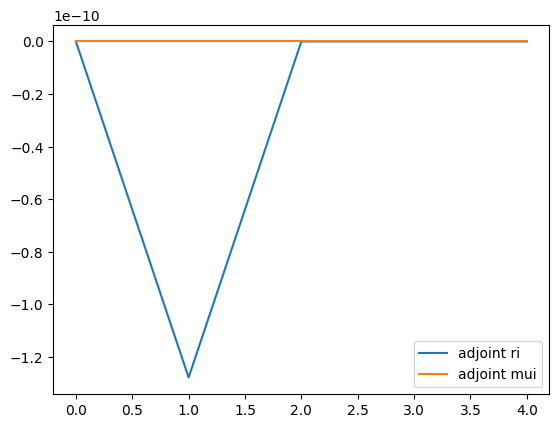

[0.         0.01066185 0.01071543 0.00863768 0.00462823]


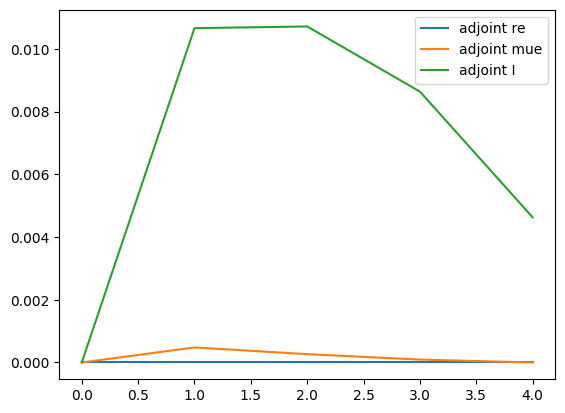

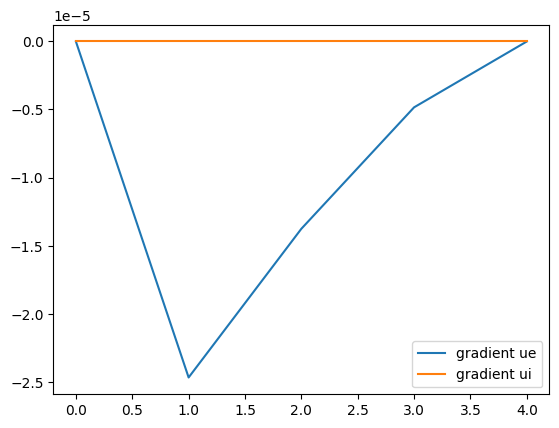

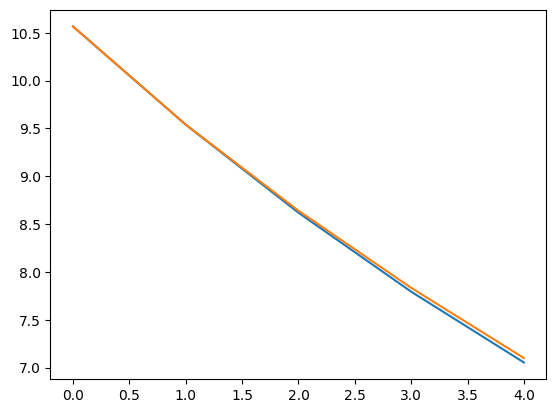

In [9]:
cost_mat = np.zeros((1,len(model.output_vars)))
cost_mat[0,2] = 1

control_mat = np.zeros((1,len(model.input_vars)))
control_mat[0,0] = 1

model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,1001,10), cost_matrix = cost_mat, control_matrix=control_mat)
model_controlled.update_input()

model_controlled.optimize(1)

plt.plot(model_controlled.adjoint_state[0,1,:], label="adjoint ri")
plt.plot(model_controlled.adjoint_state[0,3,:], label="adjoint mui")
#plt.plot(model_controlled.adjoint_state[0,7,:], label="adjoint sie")
plt.legend()
plt.show()

plt.plot(model_controlled.adjoint_state[0,0,:], label="adjoint re")
plt.plot(model_controlled.adjoint_state[0,2,:], label="adjoint mue")
plt.plot(model_controlled.adjoint_state[0,4,:], label="adjoint I")
print(model_controlled.adjoint_state[0,4,:])
plt.legend()
plt.show()

plt.plot(model_controlled.gradient[0,0,:], label="gradient ue")
plt.plot(model_controlled.gradient[0,1,:], label="gradient ui")
plt.legend()
plt.show()

plt.plot(model_controlled.get_xs()[0,2,:])
plt.plot(model_controlled.target[0,2,:])
plt.show()

#plot_oc_singlenode(duration, dt, model_controlled.get_xs(), target, model_controlled.control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.00021087163287796952
Cost in iteration 100: 3.4797742904843413e-09
Cost in iteration 200: 1.9274286223566826e-10
Cost in iteration 300: 1.1098880929073168e-11
Cost in iteration 400: 6.034086674726175e-13
Cost in iteration 500: 3.342673493298439e-14
Cost in iteration 600: 1.8651311450626724e-15
Cost in iteration 700: 1.0524261186506896e-16
Cost in iteration 800: 5.80041343439389e-18
Cost in iteration 900: 3.23020331647283e-19
Cost in iteration 1000: 1.8420924511253972e-20
Final cost : 1.8420924511253972e-20


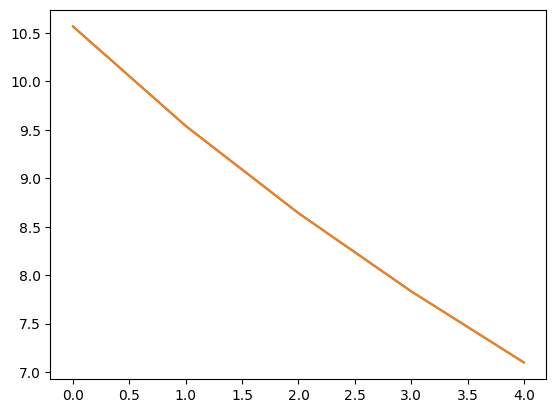

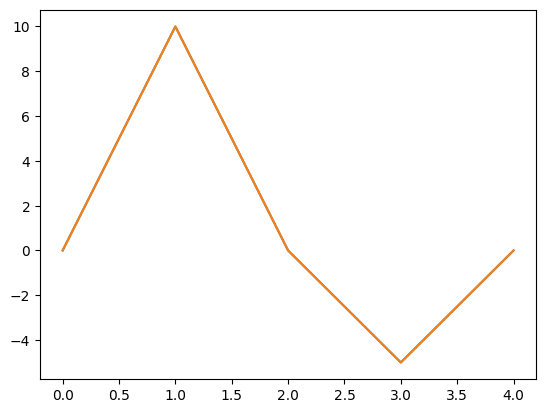

In [10]:
model_controlled.print_array = np.arange(0,10001, 100)
model_controlled.optimize(1000)

if False:
    plt.plot(model_controlled.adjoint_state[0,1,:], label="adjoint ri")
    plt.plot(model_controlled.adjoint_state[0,3,:], label="adjoint mui")
    plt.plot(model_controlled.adjoint_state[0,7,:], label="adjoint sie")
    plt.legend()
    plt.show()
    plt.plot(model_controlled.adjoint_state[0,0,:], label="adjoint re")
    plt.plot(model_controlled.adjoint_state[0,2,:], label="adjoint mue")
    plt.legend()
    plt.show()
    plt.plot(model_controlled.gradient[0,0,:], label="gradient ue")
    plt.plot(model_controlled.gradient[0,1,:], label="gradient ui")
    plt.legend()
    plt.show()

plt.plot(model_controlled.get_xs()[0,2,:])
plt.plot(model_controlled.target[0,2,:])
plt.show()

plt.plot(model_controlled.control[0,0,:])
plt.plot(input[0,:])
plt.show()

#plot_oc_singlenode(duration, dt, model_controlled.get_xs(), target, model_controlled.control, target_input, model_controlled.cost_history)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

def getfinalstate(model):
    N = len(model.params.Cmat)
    V = len(model.state_vars)
    T = model.getMaxDelay()+1
    state = np.zeros((N, V, T))
    for n in range(N):
        for v in range(V):
            if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
                state[n,v,:] = model.state[model.state_vars[v]][n, -T:]
                
            else:
                state[n,v,:] = model.state[model.state_vars[v]][n]
    return state

def setinitstate(model, state):
    N = len(model.params.Cmat)
    V = len(model.init_vars)
    T = model.getMaxDelay()+1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:,v,-T:]
            else:
                model.params[model.init_vars[v]] = state[:,v,-1]

    return

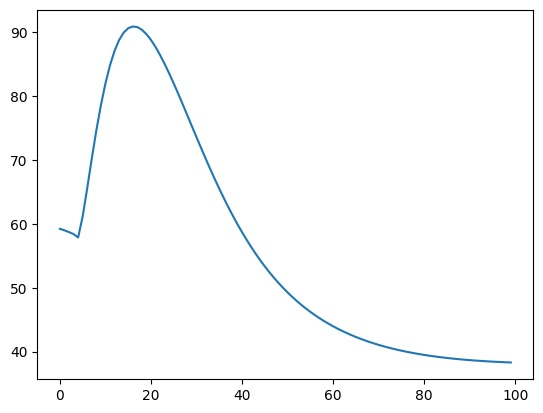

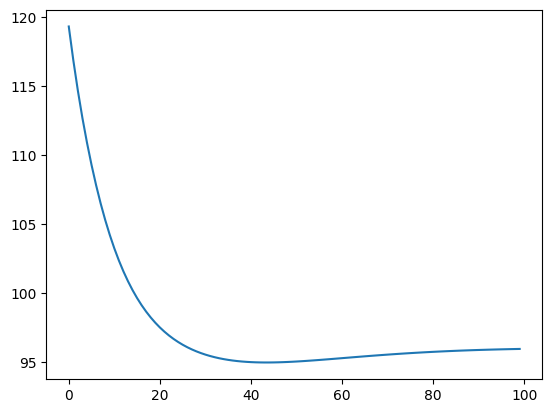

In [2]:
model = ALNModel()

model.params.de = 0.2
model.params.di = 0.1
ndt_de = np.around(model.params.de / model.params.dt).astype(int)
ndt_di = np.around(model.params.di / model.params.dt).astype(int)

# intermediate external input to membrane voltage to not reach the boundaries of the transfer function
model.params.mue_ext_mean = 2.0
model.params.mui_ext_mean = 0.5

# no noise
model.params.sigma_ou = 0.0

# adaptation parameters
model.params.a = 4
model.params.b = 0
model.params.tauA = 1.0

model.params.mue_ou = model.params.mue_ext_mean * np.ones((1,))
model.params.mui_ou = model.params.mui_ext_mean * np.ones((1,))
model.params.mufe_init = model.params.mue_ext_mean * np.ones((1,))
model.params.mufi_init = model.params.mui_ext_mean * np.ones((1,))

model.params["duration"] = max(10, 2 * model.getMaxDelay())
model.run()

plt.plot(model.rates_exc[0, :])
plt.show()
plt.plot(model.IA[0, :])
plt.show()

----------------- input channel, mesure channel =  0 2


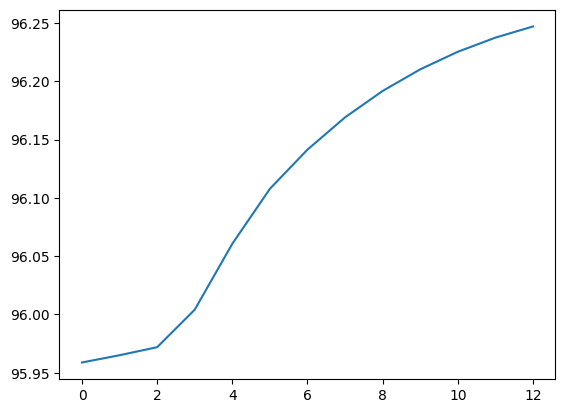

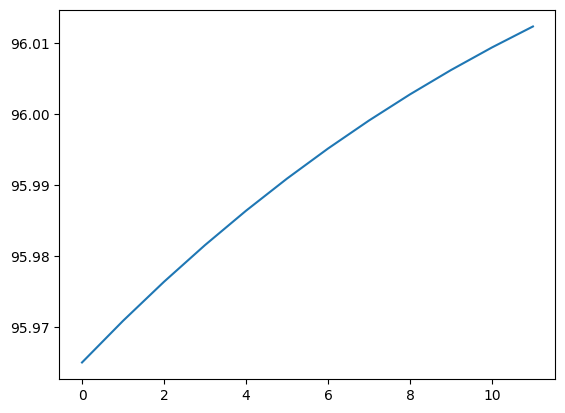

In [3]:
setinitstate(model, getfinalstate(model))
if (
    model.params.rates_exc_init[0, -1] < 5
    or model.params.rates_inh_init[0, -1] < 5
    or model.params.rates_exc_init[0, -1] > 150
    or model.params.rates_inh_init[0, -1] > 150
):
    print("WARNING------------------------")
    print("Rates might be out of table range")
    print(model.params.rates_exc_init[0, -1], model.params.rates_inh_init[0, -1])

# Test duration
duration = 1.0 + max(model.params.de, model.params.di)
a = 1.0  # amplitude

zero_input = ZeroInput().generate_input(duration=duration + model.params.dt, dt=model.params.dt)
input = np.copy(zero_input)
inp_init = np.copy(zero_input)

from numpy.random import RandomState, SeedSequence, MT19937
rs = RandomState(MT19937(SeedSequence(0)))  # work with fixed seed for reproducibility

intinit, intend = 1, input.shape[1] - 5 - max(ndt_de, ndt_di)

for t in range(intinit, intend):
    input[0, t] = rs.uniform(-a, a)
    inp_init[0, t] = input[0, t] + 1e-2 * a * rs.uniform(-a, a)

input_channel, measure_channel = 0,2

print("----------------- input channel, mesure channel = ", input_channel, measure_channel)

cost_mat = np.zeros((model.params.N, len(model.output_vars)))
control_mat = np.zeros((model.params.N, len(model.input_vars)))
model.params["ext_exc_current"] = input
model.params["ext_inh_current"] = zero_input

cost_mat[0, measure_channel] = 1.0
control_mat[0, input_channel] = 1.0

model.params["duration"] = duration
model.run()

target = np.concatenate(
    (
        np.concatenate(
            (
                model.params["rates_exc_init"][:, np.newaxis, -1],
                model.params["rates_inh_init"][:, np.newaxis, -1],
                model.params["IA_init"][:, np.newaxis, -1],
            ),
            axis=1,
        )[:, :, np.newaxis],
        np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),
    ),
    axis=2,
)

plt.plot(target[0, 2, :])
plt.show()

control_init = np.zeros((target.shape))
control_init[0, input_channel, :] = inp_init[0, :]

model.params["ext_exc_current"] = zero_input
model.params["ext_inh_current"] = zero_input

model.run()
plt.plot(model.IA[0, :])
plt.show()


Compute control for a deterministic system
Cost in iteration 0: 0.015479517138393455
Final cost : 3.916950304865688e-11
[0.00071463 0.00135275 0.00050416 0.00109358 0.00164543]


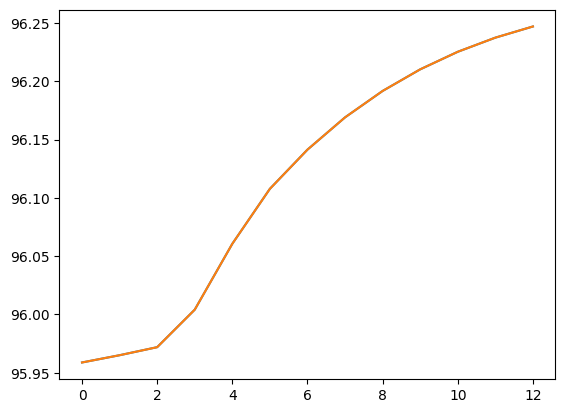

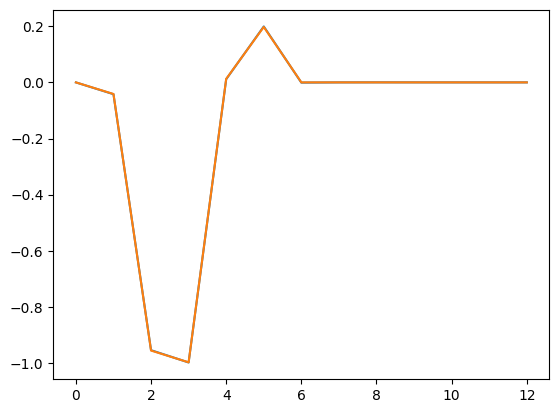

In [4]:
model_controlled = oc_aln.OcAln(model, target, control_matrix=control_mat, cost_matrix=cost_mat)
control_coincide = False
iterations = 1000

model_controlled.control = control_init.copy()

model_controlled.optimize(iterations)
control = model_controlled.control

c_diff = np.abs(control[0, input_channel, intinit:intend] - input[0, intinit:intend])
print(c_diff)

plt.plot(model_controlled.get_xs()[0,2,:])
plt.plot(model_controlled.target[0,2,:])
plt.show()

plt.plot(model_controlled.control[0,0,:])
plt.plot(input[0,:])
plt.show()

Compute control for a deterministic system
Cost in iteration 0: 3.916950304865688e-11
Final cost : 2.736452370620286e-13
[1.55479113e-05 2.21939498e-05 2.47142178e-05 1.16185236e-04
 1.76872626e-04]


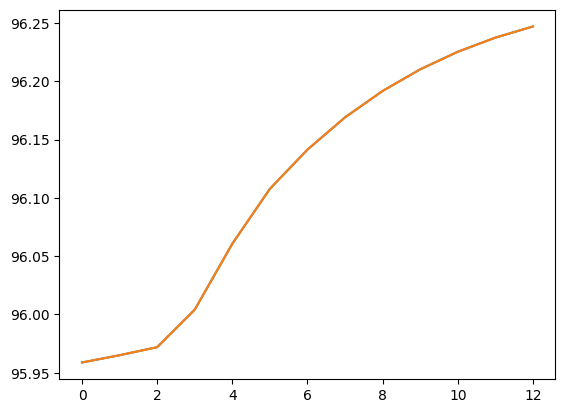

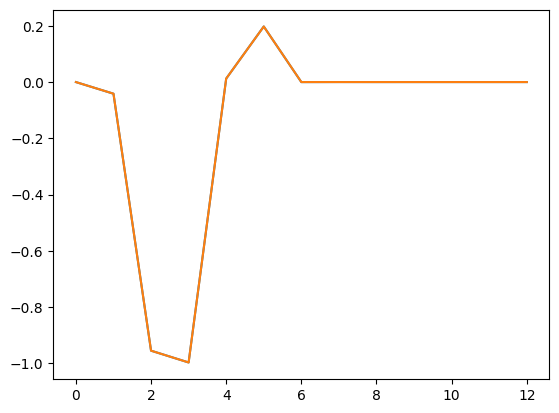

In [5]:
iterations= 10000
model_controlled.optimize(iterations)
control = model_controlled.control

c_diff = np.abs(control[0, input_channel, intinit:intend] - input[0, intinit:intend])
print(c_diff)

plt.plot(model_controlled.get_xs()[0,2,:])
plt.plot(model_controlled.target[0,2,:])
plt.show()

plt.plot(model_controlled.control[0,0,:])
plt.plot(input[0,:])
plt.show()